In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

In [2]:
# Load CSV files\
df_data = pd.read_csv('pandas/df_data.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered.csv')

agg_df_cluster1 = pd.read_csv('pandas/agg_df_cluster1.csv')
fish_df_cluster1 = pd.read_csv('pandas/fish_df_cluster1.csv')

In [3]:
# designate which clustering to analyze
df_explore = agg_df_cluster1 # agg_df or agg_df_large or agg_df_top2
fish_explore = fish_df_cluster1 # fish_df or fish_df_large or fish_df_top2


Cluster sizes:
cluster
1     959
2     450
3     372
4     224
5      89
6      36
7      34
8      34
9      23
10     14
11     12
12     11
14      9
15      9
13      9
17      7
16      7
18      6
19      6
20      6
21      6
22      6
23      6
24      6
25      5
26      5
29      4
30      4
28      4
27      4
dtype: int64


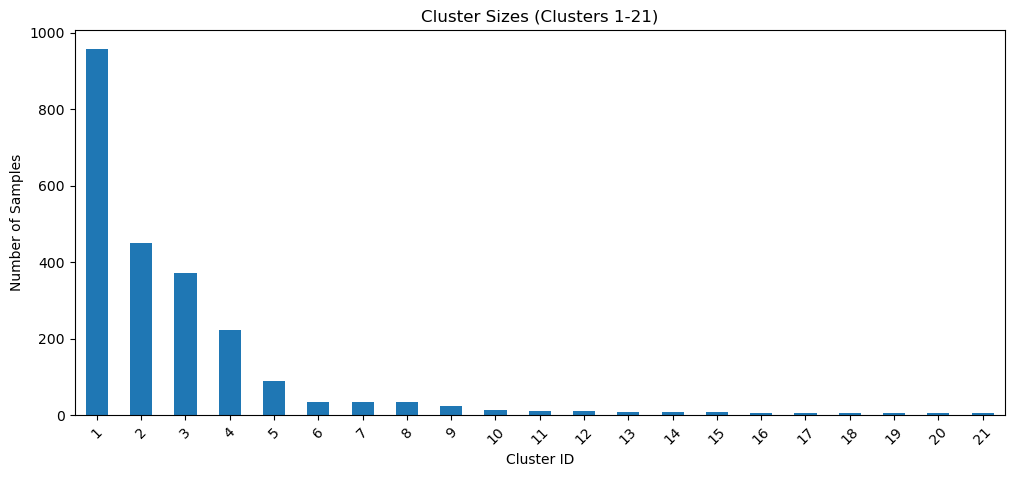

In [4]:
# Summary of clusters
cluster_summary = df_explore.groupby('cluster').size().sort_values(ascending=False)
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Filter to only clusters 1-21
clusters_to_show = range(1, 22)
cluster_summary_filtered = cluster_summary[cluster_summary.index.isin(clusters_to_show)].sort_index()

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary_filtered.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title('Cluster Sizes (Clusters 1-21)')
plt.xticks(rotation=45);

# Cluster Species Composition

We next inspected how each cluster varied in it’s species composition.

We will produce three vertical heatmaps for the Jaccard clustering method. Each heatmap shows the average percent presence of each fish species (rows) within each cluster (columns).

*What the graph means:*

-   **Columns**: Each column is a cluster of assemblages (sites grouped by fish community similarity).
-   **Rows**: Each row is a fish species (only those present in >10% of any cluster).
-   **Cell values**: The number in each cell is the percent of assemblages in that cluster where the species is present (0–100%).
-   **Color**: Darker blue = higher percent presence.
-   **Interpretation**: You can see which species are common or rare in each cluster, and how species composition differs between clusters and clustering methods.

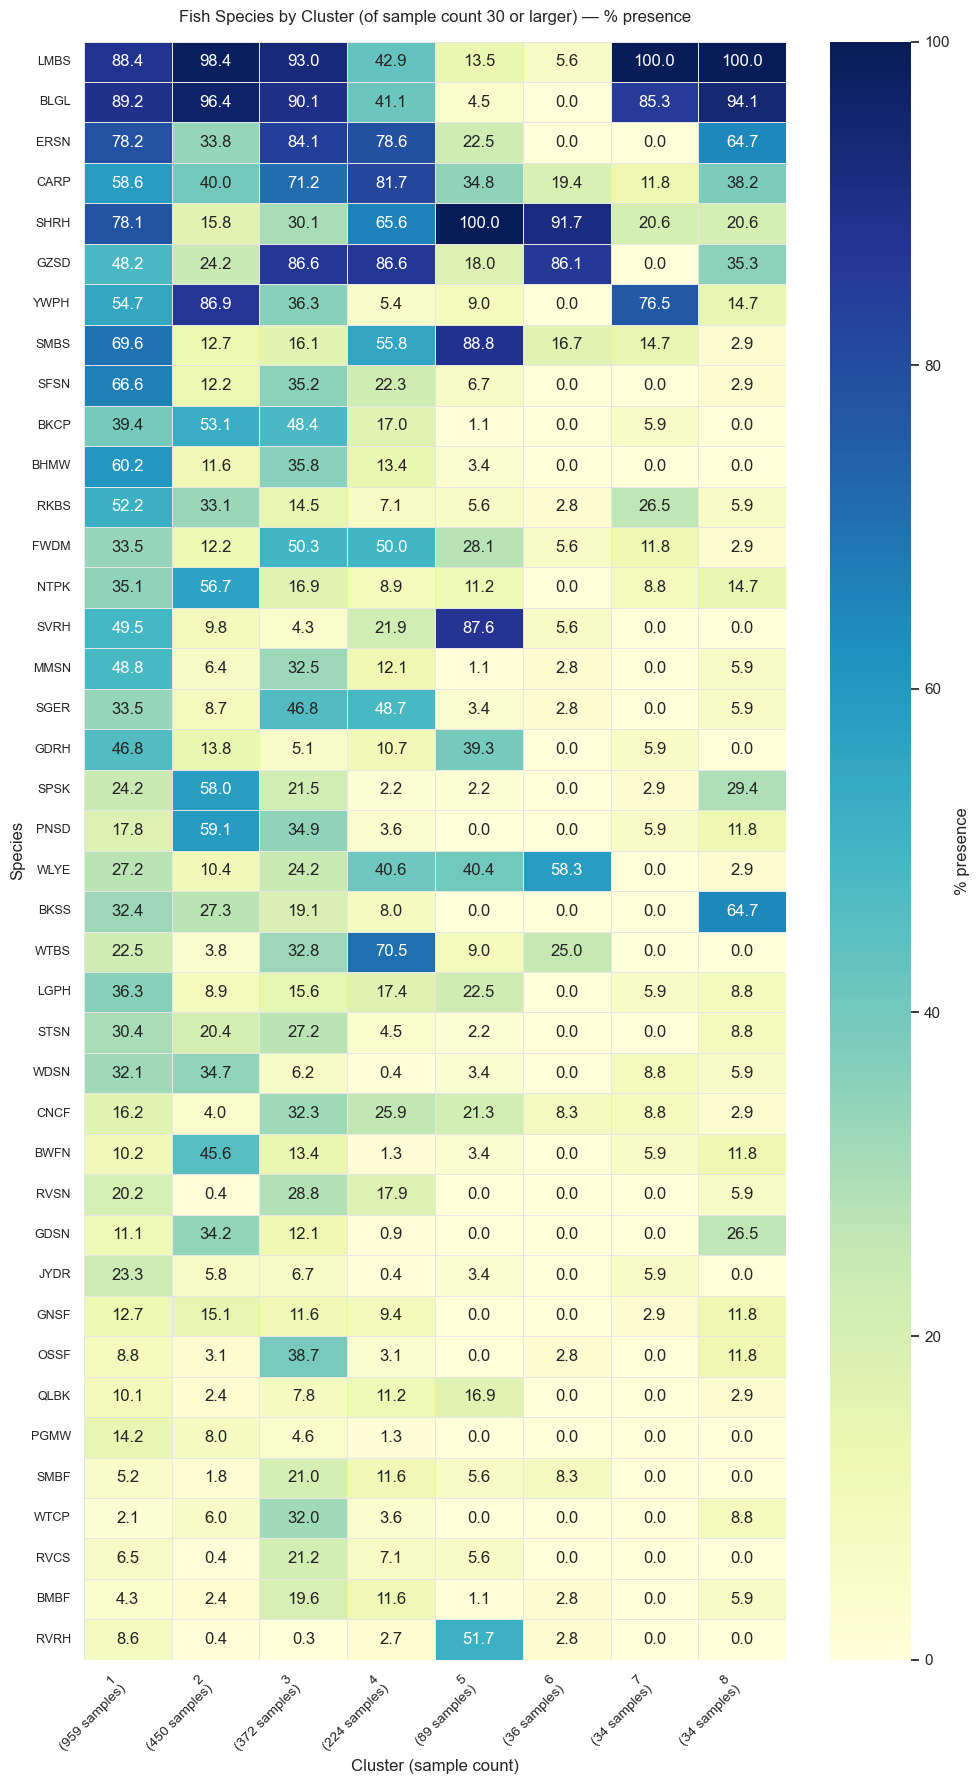

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("notebook", font_scale=1.0)

# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_order = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Keep only top 20 most common species
fishcode_2_include = 41
top_species = species_order[:fishcode_2_include]

# Compute percent presence per cluster for top 20 species only
# Result: rows = cluster, cols = species
jac_comp = fish_explore.groupby('cluster')[top_species].mean() * 100

# Order clusters by overall sample count (so columns are in meaningful order)
# Filter clusters with size >= 10
# 4 cluster size > 160
# 8 cluster size > 30
cluster_filter = 30
cluster_sizes = df_explore['cluster'].value_counts()
cluster_sizes = cluster_sizes[cluster_sizes >= cluster_filter]
cluster_order = [c for c in cluster_sizes.index if c in jac_comp.index]
jac_comp = jac_comp.reindex(cluster_order)

# Transpose so rows=species, cols=cluster (more natural for reading species)
display_df = jac_comp.T

# Create readable cluster labels with site counts
col_labels = [f"{c}\n({cluster_sizes.get(c,0)} samples)" for c in display_df.columns]

# Plot
fig, ax = plt.subplots(figsize=(max(10, 0.6 * display_df.shape[1]), 0.35 * display_df.shape[0] + 4))
cmap = sns.color_palette("YlGnBu", as_cmap=True)  # perceptually-uniform sequential

sns.heatmap(
    display_df,
    ax=ax,
    cmap=cmap,
    vmin=0,
    vmax=100,
    annot=True,
    fmt=".1f",
    linewidths=0.4,
    linecolor="0.9",
    cbar_kws={"label": "% presence"}
)

ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_xlabel("Cluster (sample count)")
ax.set_ylabel("Species")
ax.set_title(f"Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
#ax.set_title(f"Top {fishcode_2_include} Most Common Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
plt.tight_layout()
plt.show()
fig.savefig(
    'cluster_species_presence.jpg',
    dpi=300,
    bbox_inches='tight',
    format='jpeg',
    pil_kwargs={'quality': 95, 'optimize': True, 'progressive': True}
)


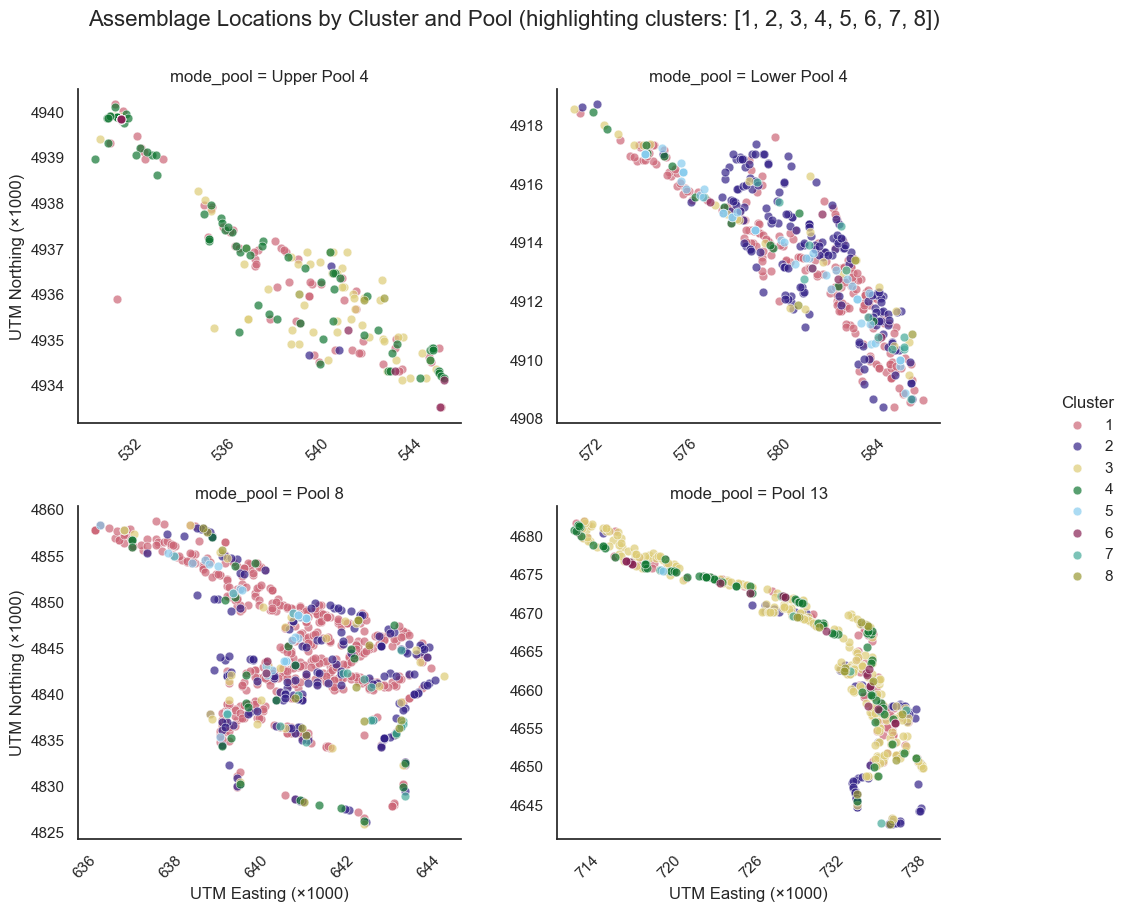

In [6]:
import tol_colors as tc

CB_PALETTE = tc.muted
# Fallback colors for clusters > 8
EXTRA_COLORS = [ '#44AA99', '#999933','#882255', '#AA4499']
GREY_COLOR = (0.75, 0.75, 0.75)  # light gray for non-highlighted clusters

# =============================================================================
# CONFIGURATION: Select clusters to highlight
# =============================================================================
highlight_clusters = [1, 2, 3, 4, 5, 6, 7, 8]  # <-- CHANGE THIS to select clusters (set to None or [] to show all)

# Minimum cluster size filter
min_cluster_size = 30

# Define pool order for facets (2 columns: row1 = Pool 4s, row2 = Pool 8 & 13)
pool_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]

# =============================================================================
# Data preparation
# =============================================================================
# Filter cluster size over threshold
cluster_counts = df_explore['cluster'].value_counts()
clusters_over_threshold = cluster_counts[cluster_counts >= min_cluster_size].index
df_plot = df_explore[df_explore['cluster'].isin(clusters_over_threshold)].copy()

# Filter to only include pools in our desired order
df_plot = df_plot[df_plot['mode_pool'].isin(pool_order)].copy()

# Set mode_pool as ordered categorical to control facet order
df_plot['mode_pool'] = pd.Categorical(
    df_plot['mode_pool'], 
    categories=pool_order, 
    ordered=True
)

cluster_sizes = df_plot['cluster'].value_counts()
unique_clusters = sorted(df_plot['cluster'].unique())

# =============================================================================
# Build color map: use consistent CB colors, grey out non-highlighted clusters
# =============================================================================

# create a color map for highlighed clusters mapped to CB_PALETTE colors
color_map = {}
for idx, cluster_id in enumerate(unique_clusters):
    if highlight_clusters and cluster_id not in highlight_clusters:
        color_map[cluster_id] = GREY_COLOR
    else:
        if idx < len(CB_PALETTE):
            color_map[cluster_id] = CB_PALETTE[idx]
        else:
            extra_color_idx = (idx - len(CB_PALETTE)) % len(EXTRA_COLORS)
            color_map[cluster_id] = EXTRA_COLORS[extra_color_idx]


g = sns.FacetGrid(
    df_plot,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=2,
    height=5,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=40)

# Format axes in thousands
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1000:.0f}'))

g.set_axis_labels("UTM Easting (×1000)", "UTM Northing (×1000)")

# Add legend positioned closer to the plots
g.add_legend(title="Cluster", bbox_to_anchor=(1.0, 0.5), loc='center left')

# Update title
if highlight_clusters:
    title_suffix = f" (highlighting clusters: {highlight_clusters})"
else:
    title_suffix = ""
g.figure.suptitle(f"Assemblage Locations by Cluster and Pool{title_suffix}", fontsize=16)

# Adjust layout with more bottom space for rotated labels and proper right margin
g.figure.subplots_adjust(right=0.9, bottom=0.15, top=0.90, hspace=0.25, wspace=0.25)

plt.show()

## Clusters over time

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import f as f_dist
from plotnine import *

# Calculate proportion of samples in each cluster per year
cluster_time = df_explore.groupby(['year', 'cluster']).size().reset_index(name='count')
total_per_year = cluster_time.groupby('year')['count'].transform('sum')
cluster_time['proportion'] = cluster_time['count'] / total_per_year
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Calculate proportion per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
total_per_year_pool = cluster_time_pool.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_time_pool['proportion'] = cluster_time_pool['count'] / total_per_year_pool
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
grp_size2 = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = cluster_time_pool[grp_size2 >= 2]

# ensure desired pool order and filter to clusters < 5
desired_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]


cluster_filter = [1,2,3,4, 5, 6, 7, 8]
cluster_time_pool_lt5 = cluster_time_pool[cluster_time_pool['cluster'].astype(int).isin(cluster_filter)].copy()
filtered_smooth_lt5 = filtered_smooth[filtered_smooth['cluster'].astype(int).isin(cluster_filter)].copy()

cluster_time_pool_lt5['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
filtered_smooth_lt5['mode_pool'] = pd.Categorical(filtered_smooth_lt5['mode_pool'], categories=desired_order, ordered=True)


# =====================================================================
# SEGMENTED REGRESSION FOR ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

def piecewise_linear(x, x0, y0, m1, m2):
    """
    Continuous piecewise linear function with breakpoint at x0.
    Left (x <= x0): y = y0 + m1*(x - x0)
    Right (x > x0): y = y0 + m2*(x - x0)
    """
    return np.piecewise(
        x,
        [x <= x0, x > x0],
        [lambda z: y0 + m1 * (z - x0),
         lambda z: y0 + m2 * (z - x0)]
    )

def fit_segmented_regression(years, proportions, min_points=6):
    """
    Fit continuous segmented regression with one breakpoint using curve_fit.
    
    Returns:
    --------
    dict with fit results or None if insufficient data
    """
    years = np.asarray(years, dtype=float)
    proportions = np.asarray(proportions, dtype=float)
    
    if len(years) < min_points:
        return None
    
    # Initial guesses
    x0_guess = np.median(years)
    y0_guess = proportions[np.argmin(np.abs(years - x0_guess))]
    m1_guess = 0.0
    m2_guess = 0.0
    p0 = [x0_guess, y0_guess, m1_guess, m2_guess]
    
    # Bounds: keep breakpoint inside observed range
    bounds = (
        [years.min(), -np.inf, -np.inf, -np.inf],
        [years.max(),  np.inf,  np.inf,  np.inf]
    )
    
    try:
        # Fit piecewise model
        params, cov = optimize.curve_fit(
            piecewise_linear,
            years, proportions,
            p0=p0,
            bounds=bounds,
            maxfev=10000
        )
        
        x0_fit, y0_fit, m1_fit, m2_fit = params
        y_hat = piecewise_linear(years, *params)
        rss_piece = np.sum((proportions - y_hat)**2)
        
        # Simple linear model for comparison
        slope_simple, intercept_simple = np.polyfit(years, proportions, 1)
        y_hat_simple = slope_simple * years + intercept_simple
        rss_simple = np.sum((proportions - y_hat_simple)**2)
        
        # F-test
        n = len(years)
        k_piece = 4  # x0, y0, m1, m2
        k_simple = 2
        
        if n > k_piece and rss_piece > 0:
            f_stat = ((rss_simple - rss_piece) / (k_piece - k_simple)) / (rss_piece / (n - k_piece))
            p_value = 1 - f_dist.cdf(f_stat, k_piece - k_simple, n - k_piece)
        else:
            f_stat = np.nan
            p_value = np.nan
        
        return {
            'breakpoint': x0_fit,
            'y_at_break': y0_fit,
            'slope_before': m1_fit,
            'slope_after': m2_fit,
            'rss_piecewise': rss_piece,
            'rss_simple': rss_simple,
            'improvement_pct': 100 * (rss_simple - rss_piece) / rss_simple if rss_simple > 0 else 0,
            'f_stat': f_stat,
            'p_value': p_value,
            'significant': (p_value < 0.05) if not np.isnan(p_value) else False,
            'n_points': n,
            'params': params,
            'cov': cov
        }
    
    except Exception as e:
        print(f"  Warning: Fit failed - {str(e)}")
        return None

# =====================================================================
# FIT ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

results = []
fitted_data = []

for (pool, cluster), grp in cluster_time_pool_lt5.groupby(['mode_pool', 'cluster'], observed=False):
    # Sort and convert to numpy
    sub = grp[['year', 'proportion']].dropna().sort_values('year')
    years = sub['year'].to_numpy(dtype=float)
    props = sub['proportion'].to_numpy(dtype=float)
    
    res = fit_segmented_regression(years, props)
    
    if res:
        # Store results
        results.append({
            'mode_pool': pool,
            'cluster': cluster,
            'breakpoint_year': res['breakpoint'],
            'y_at_breakpoint': res['y_at_break'],
            'slope_before': res['slope_before'],
            'slope_after': res['slope_after'],
            'improvement_pct': res['improvement_pct'],
            'f_statistic': res['f_stat'],
            'p_value': res['p_value'],
            'significant': res['significant'],
            'n_points': res['n_points']
        })
        
        # Generate fitted values for plotting
        y_fitted = piecewise_linear(years, *res['params'])
        for yr, y_fit in zip(years, y_fitted):
            fitted_data.append({
                'mode_pool': pool,
                'cluster': cluster,
                'year': yr,
                'fitted': y_fit
            })

# Convert to DataFrames
segmented_results_df = pd.DataFrame(results).sort_values(['mode_pool', 'cluster'])
fitted_values_df = pd.DataFrame(fitted_data)

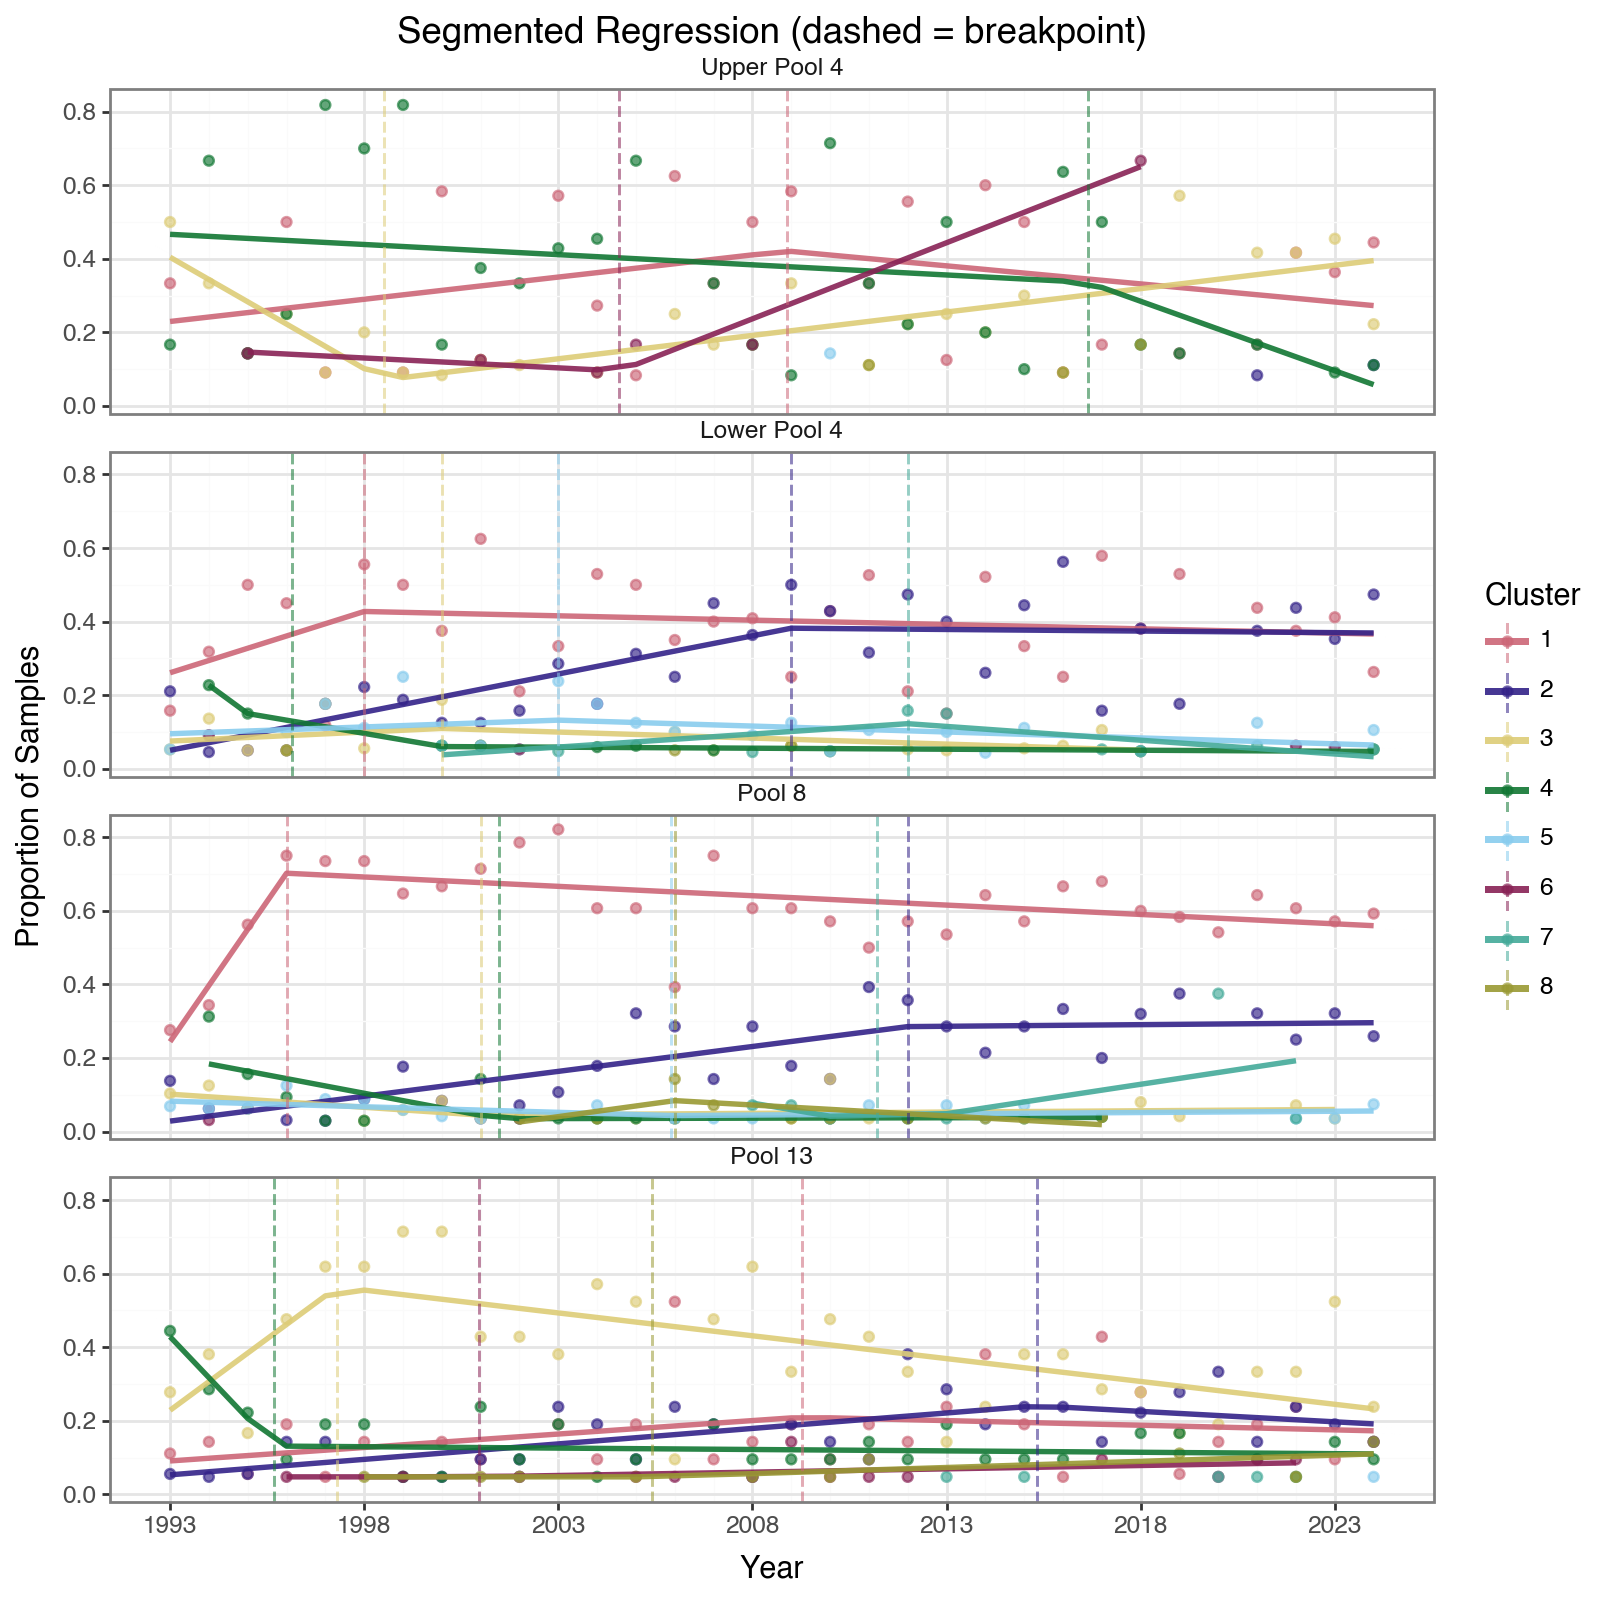

In [96]:
annotated_data = cluster_time_pool_lt5.merge(
     segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 'significant']],
     on=['mode_pool', 'cluster'],
     how='left'
)

annotated_data['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
fitted_values_df['mode_pool'] = pd.Categorical(fitted_values_df['mode_pool'], categories=desired_order, ordered=True)
# Filter out rows with missing breakpoint_year for the vline layer
breakpoint_data = annotated_data.dropna(subset=['breakpoint_year'])

# Display plot
(
    ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
    geom_point(size=1.5, alpha=0.65) +
    geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
              size=1.1, alpha=0.9) +
    geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
               linetype='dashed', alpha=0.55, size=0.6) +
    facet_wrap('~mode_pool', ncol=1) +
    scale_color_manual(values=CB_PALETTE) +
    labs(x='Year', y='Proportion of Samples', color='Cluster',
         title='Segmented Regression (dashed = breakpoint)') +
    theme_bw() +
    theme(figure_size=(7, 7), strip_background=element_blank())
)

# Save the plot using ggsave
p = (
     ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
     geom_point(size=1.5, alpha=0.65) +
     geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
                 size=1.1, alpha=0.9) +
     geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
                  linetype='dashed', alpha=0.55, size=0.6) +
     facet_wrap('~mode_pool', ncol=1) +
     scale_x_continuous(minor_breaks=range(1993, 2024, 1), breaks=range(1993, 2024, 5)) +
     scale_color_manual(values=CB_PALETTE) +
     labs(x='Year', y='Proportion of Samples', color='Cluster',
           title='Segmented Regression (dashed = breakpoint)') +
     theme_bw() +
     theme(figure_size=(8, 8), strip_background=element_blank())
)

p.save('segmented_regression_clusters.jpg', dpi=300, verbose=False)
p.show()

table of average and variance (over time) of proportion for each cluster and reach

In [94]:
# Build a complete year x cluster grid per reach (mode_pool), fill missing proportions with 0,
# then compute mean and variance of proportions over time for each cluster within each reach.
# Filter to only highlight_clusters

# Convert highlight_clusters to strings for comparison
highlight_clusters_str = [str(c) for c in highlight_clusters]

# Ensure we use clusters present at least once per reach
years_by_pool = {
    pool: np.sort(df_explore.loc[df_explore['mode_pool'] == pool, 'year'].unique())
    for pool in df_explore['mode_pool'].unique()
}
clusters_by_pool = {
    pool: sorted(
        [c for c in cluster_time_pool.loc[cluster_time_pool['mode_pool'] == pool, 'cluster'].unique()
         if c in highlight_clusters_str],
        key=int
    )
    for pool in cluster_time_pool['mode_pool'].unique()
}

grid_frames = []
for pool, years in years_by_pool.items():
    clusters = clusters_by_pool.get(pool, [])
    if len(clusters) == 0 or len(years) == 0:
        continue
    grid_frames.append(
        pd.MultiIndex.from_product(
            [[pool], clusters, years],
            names=['mode_pool', 'cluster', 'year']
        ).to_frame(index=False)
    )
full_grid = pd.concat(grid_frames, ignore_index=True)

# Merge with proportions and fill missing with 0 (cluster absent that year)
prop_full = full_grid.merge(
    cluster_time_pool[['mode_pool', 'cluster', 'year', 'proportion']],
    on=['mode_pool', 'cluster', 'year'],
    how='left'
)
prop_full['proportion'] = prop_full['proportion'].fillna(0.0)

# Aggregate mean and variance over time
cluster_proportion_stats = (
    prop_full.groupby(['mode_pool', 'cluster'], observed=False)['proportion']
    .agg(avg='mean', var='var', n_years='size')
    .reset_index()
)

# Order by desired reach order and numeric cluster order
cluster_proportion_stats['mode_pool'] = pd.Categorical(
    cluster_proportion_stats['mode_pool'],
    categories=desired_order,
    ordered=True
)
cluster_proportion_stats['cluster'] = pd.Categorical(
    cluster_proportion_stats['cluster'],
    categories=highlight_clusters_str,
    ordered=True
)
cluster_proportion_stats = cluster_proportion_stats.sort_values(['mode_pool', 'cluster']).reset_index(drop=True)

# Round for readability
cluster_proportion_stats['avg'] = cluster_proportion_stats['avg'].round(4)
cluster_proportion_stats['var'] = cluster_proportion_stats['var'].round(6)

# Print and save
print(f"\nProportion statistics for clusters: {highlight_clusters}")
print(cluster_proportion_stats.to_string(index=False))
cluster_proportion_stats.to_csv('cluster_proportion_stats_highlight.csv', index=False)


Proportion statistics for clusters: [1, 2, 3, 4, 5, 6, 7, 8]
   mode_pool cluster    avg      var  n_years
Upper Pool 4       1 0.2820 0.047400       31
Upper Pool 4       2 0.0109 0.001201       31
Upper Pool 4       3 0.1997 0.024294       31
Upper Pool 4       4 0.3373 0.061340       31
Upper Pool 4       5 0.0046 0.000658       31
Upper Pool 4       6 0.0438 0.016158       31
Upper Pool 4       8 0.0119 0.001467       31
Lower Pool 4       1 0.3864 0.018547       31
Lower Pool 4       2 0.2880 0.021373       31
Lower Pool 4       3 0.0438 0.002742       31
Lower Pool 4       4 0.0265 0.002579       31
Lower Pool 4       5 0.0845 0.004243       31
Lower Pool 4       6 0.0085 0.000538       31
Lower Pool 4       7 0.0219 0.001751       31
Lower Pool 4       8 0.0052 0.000268       31
      Pool 8       1 0.6090 0.013975       32
      Pool 8       2 0.1981 0.013868       32
      Pool 8       3 0.0340 0.001569       32
      Pool 8       4 0.0329 0.004155       32
      Pool 8      

In [14]:
# Create a multi-level column table
pivot_combined = cluster_proportion_stats.pivot(
    index='cluster', 
    columns='mode_pool', 
    values=['avg', 'var']
)
# Reorder columns to group by pool
pivot_combined = pivot_combined.swaplevel(axis=1).sort_index(axis=1)

display(pivot_combined.style.format("{:.4f}").background_gradient(cmap='Blues', axis=None))

In [15]:

display(pivot_combined.style.format("{:.4f}"))
pivot_combined.to_html('cluster_proportion_table.html', float_format='{:.4f}'.format)

In [16]:
# Create formatted table with F-stat and p-value
stats_table = segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 
                                     'f_statistic', 'p_value']].copy()

stats_table['breakpoint_year'] = stats_table['breakpoint_year'].astype(int)
stats_table['f_statistic'] = stats_table['f_statistic'].round(2)
stats_table['p_value'] = stats_table['p_value'].round(4)

# Add significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

stats_table['sig'] = stats_table['p_value'].apply(get_significance_stars)

# Reorder rows to match desired pool order
stats_table['mode_pool'] = pd.Categorical(
    stats_table['mode_pool'], 
    categories=desired_order, 
    ordered=True
)
stats_table = stats_table.sort_values(['mode_pool', 'cluster'])

print("\n" + "=" * 60)
print("SEGMENTED REGRESSION STATISTICS")
print("=" * 60)
print(stats_table.to_string(index=False))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")


SEGMENTED REGRESSION STATISTICS
   mode_pool cluster  breakpoint_year  f_statistic  p_value sig
Upper Pool 4       1             2008         0.85   0.4395    
Upper Pool 4       3             1998         9.08   0.0013  **
Upper Pool 4       4             2016         0.62   0.5481    
Upper Pool 4       6             2004         7.96   0.1116    
Lower Pool 4       1             1998         1.04   0.3665    
Lower Pool 4       2             2008         3.89   0.0328   *
Lower Pool 4       3             1999         0.55   0.5905    
Lower Pool 4       4             1996       319.01   0.0000 ***
Lower Pool 4       5             2002         0.79   0.4677    
Lower Pool 4       7             2012         2.55   0.1722    
      Pool 8       1             1995        18.71   0.0000 ***
      Pool 8       2             2012         2.22   0.1276    
      Pool 8       3             2000         1.67   0.2230    
      Pool 8       4             2001         1.82   0.2113    
      P

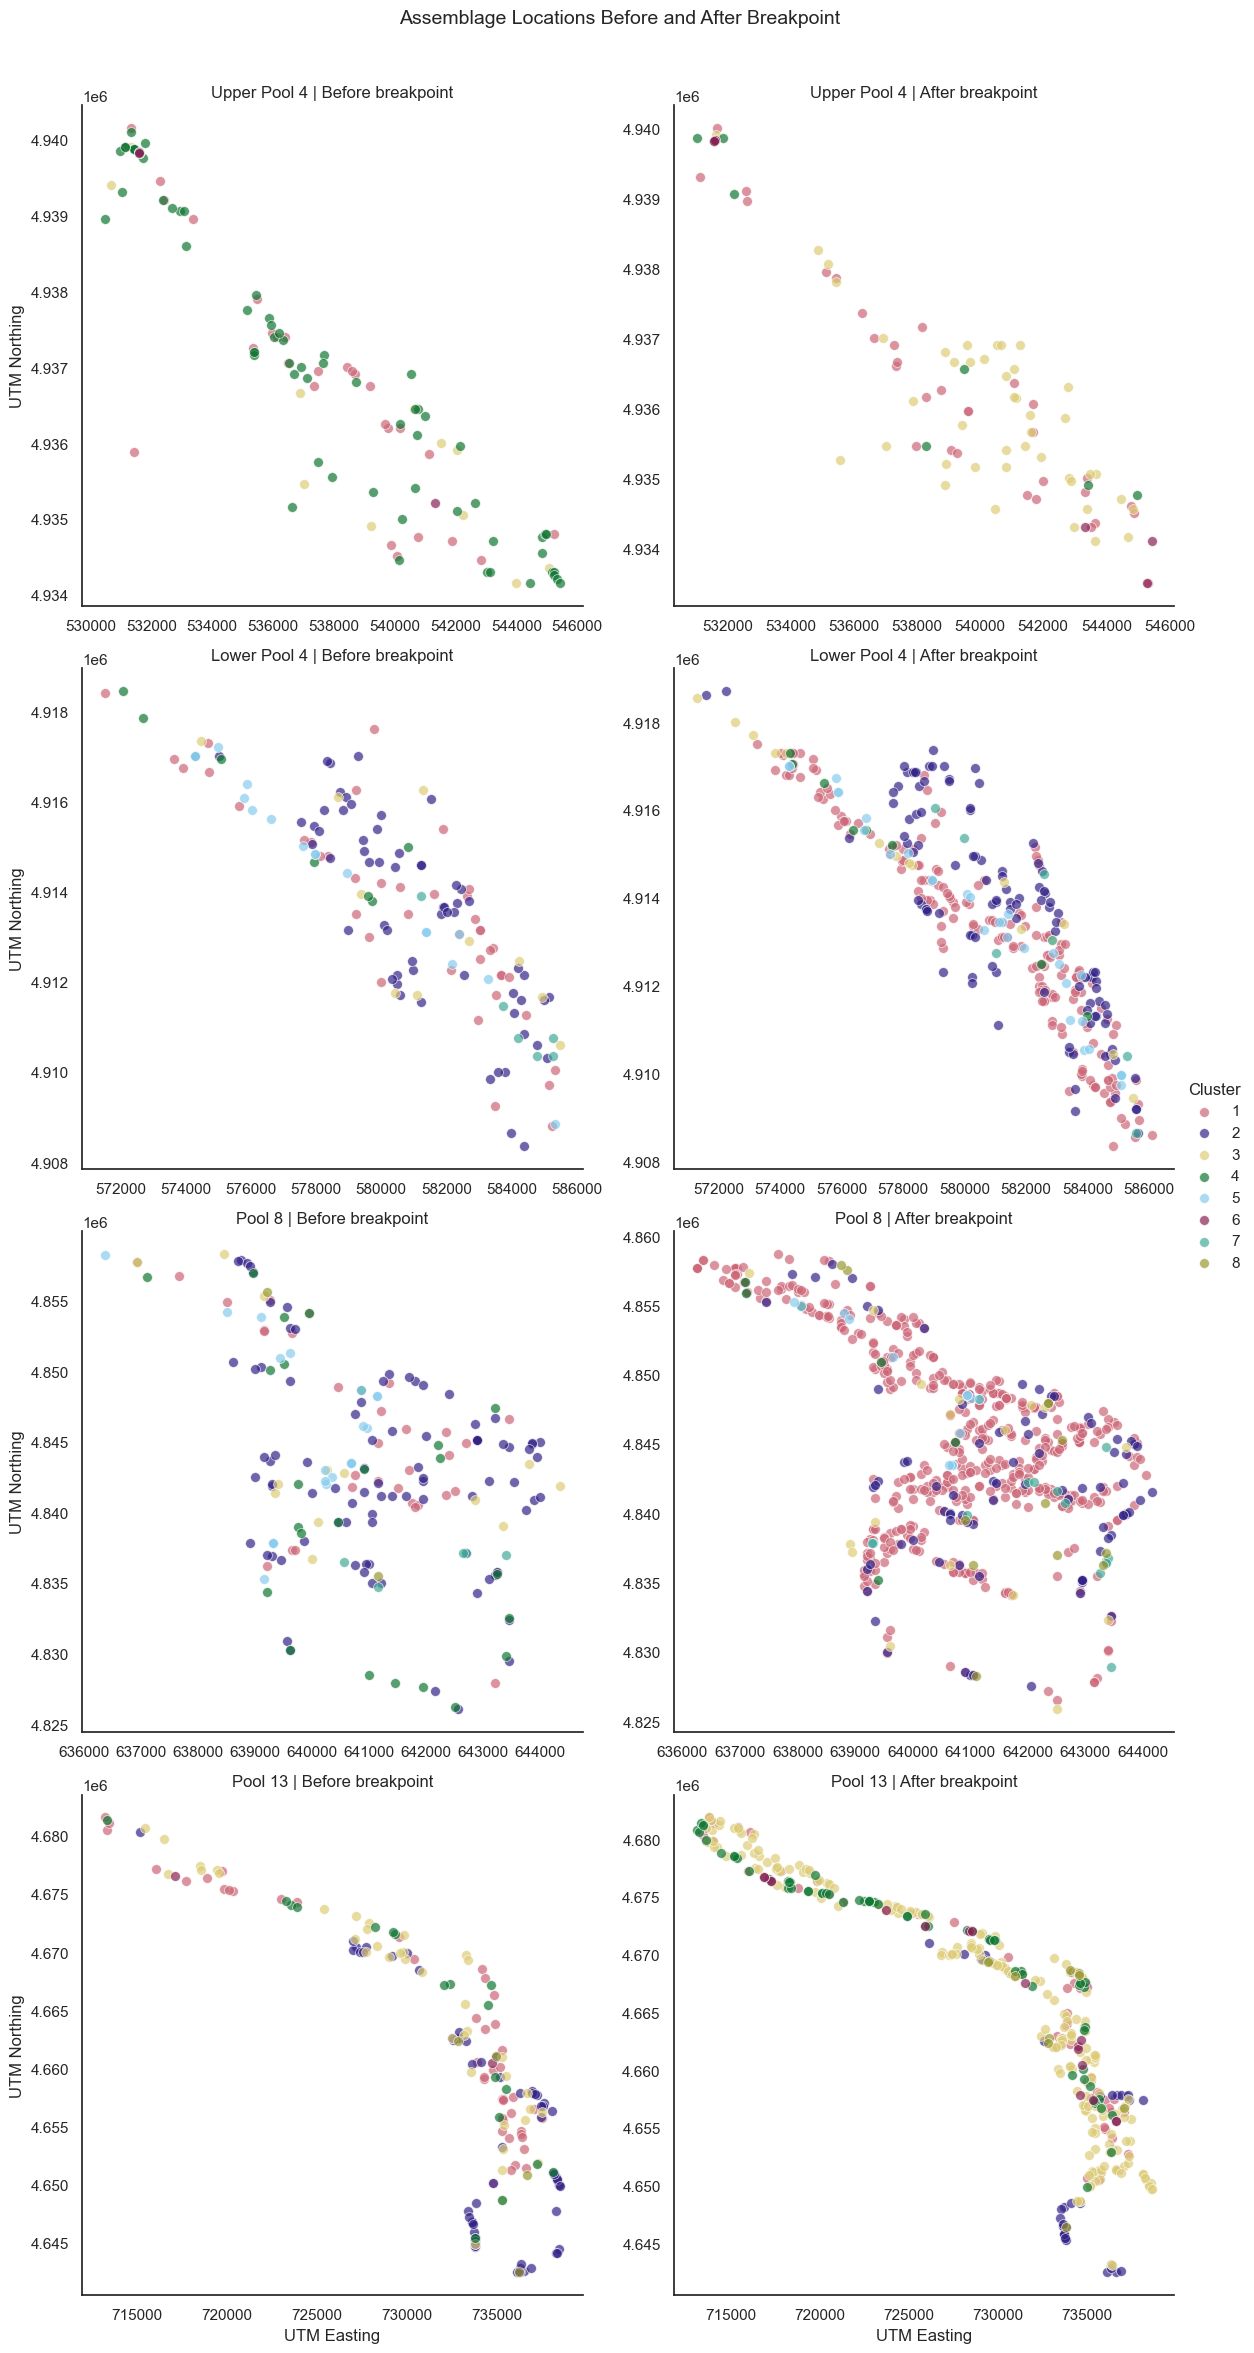

In [17]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())

# Ensure cluster dtype matches between df_explore and segmented_results_df to avoid merge errors
if 'cluster' in segmented_results_df.columns:
    target_dtype = df_explore['cluster'].dtype
    if segmented_results_df['cluster'].dtype != target_dtype:
        # If df_explore cluster is integer-like, cast segmented_results_df cluster to int
        if np.issubdtype(target_dtype, np.integer):
            segmented_results_df = segmented_results_df.copy()
            segmented_results_df['cluster'] = segmented_results_df['cluster'].astype(int)
        else:
            # otherwise cast to the same dtype as df_explore
            segmented_results_df = segmented_results_df.copy()
            segmented_results_df['cluster'] = segmented_results_df['cluster'].astype(target_dtype)

# Merge breakpoint data with df_explore
df_with_breakpoints = df_explore.merge(
    segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year']],
    on=['mode_pool', 'cluster'],
    how='left'
)

# Create before/after period column
def assign_period(row):
    if pd.isna(row['breakpoint_year']):
        return 'No breakpoint'
    elif row['year'] <= row['breakpoint_year']:
        return 'Before breakpoint'
    else:
        return 'After breakpoint'

df_with_breakpoints['period'] = df_with_breakpoints.apply(assign_period, axis=1)

# Define clusters to include (use highlight_clusters which is a list)
clusters_to_plot = highlight_clusters  # [1, 2, 3, 4, 5, 6, 7, 8]

# Filter to desired pools and clusters
df_filtered = df_with_breakpoints[
    (df_with_breakpoints['mode_pool'].isin(desired_order)) &
    (df_with_breakpoints['cluster'].isin(clusters_to_plot)) &
    (df_with_breakpoints['period'] != 'No breakpoint')
].copy()

# Set categorical order for mode_pool
df_filtered['mode_pool'] = pd.Categorical(
    df_filtered['mode_pool'], 
    categories=desired_order, 
    ordered=True
)

# Create FacetGrid with row=mode_pool, col=period
g = sns.FacetGrid(
    df_filtered,
    row="mode_pool",
    col="period",
    hue="cluster",
    palette=color_map,
    height=6,
    aspect=1,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=50)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.figure.subplots_adjust(top=.94)
g.figure.suptitle("Assemblage Locations Before and After Breakpoint", fontsize=14)
plt.show()
g.figure.savefig('assemblage_location_break.jpg', dpi=300, bbox_inches='tight')